# Zigsaw Model

### Importing Libraries

In [ ]:
# Standard library imports
import itertools
import random

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import lightning.pytorch as pl
from torchsummary import summary
from torchmetrics import Accuracy

### Hyperparameters

In [15]:
learning_rate = 1e-04
batch_size = 128
epochs = 50
img_size = (36,36)
train_ratio = 0.8
num_classes = 1024

In [8]:
class Cifar10Dataset(Dataset):
    def __init__(self, images, permutations, transforms = None):
        self.images = images
        self.transforms = transforms
        self.permutations = permutations

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transforms:
            img = self.transforms(img)
        transformed_img = img
        # Handling Permutations
        permutation_idx = np.random.randint(len(self.permutations))
        perm_order_idx = self.permutations[permutation_idx]
        permuted_img = np.zeros_like(transformed_img)
        # info about patches
        patch_height = 12
        patch_width = 12
        patches = []
        # Generating patches
        for n_patch in range(9):
            row, columns = n_patch//3, n_patch%3
            row_start, row_end = row*patch_height, (row+1)*patch_height
            columns_start, columns_end = columns*patch_width, (columns+1)*patch_width
            patches.append(transformed_img[:, row_start:row_end, columns_start:columns_end])
        
        patches = [patches[idx] for idx in perm_order_idx]
        # filling in the permuted image
        for n_patch in range(9):
            row, columns = n_patch//3, n_patch%3
            row_start, row_end = row*patch_height, (row+1)*patch_height
            columns_start, columns_end = columns*patch_width, (columns+1)*patch_width
            permuted_img[:, row_start:row_end, columns_start:columns_end] = patches[n_patch]
            patches[n_patch] = patches[n_patch].unsqueeze(0)

        patches = torch.cat(patches, 0)
        return transformed_img, permuted_img, patches, permutation_idx

In [9]:
# Constants
CIFAR10_DATA_PATH = './data/'
# Load CIFAR10 dataset for training and testing
cifar10_train_data = datasets.CIFAR10(CIFAR10_DATA_PATH, train=True, transform=None,download=True)
cifar10_test_data = datasets.CIFAR10(CIFAR10_DATA_PATH, train=False, download=True)

# Generate and shuffle permutations
possible_permutations = list(itertools.permutations(range(9)))
random.shuffle(possible_permutations)
selected_permutations = possible_permutations[:num_classes]

Files already downloaded and verified
Files already downloaded and verified


### Data Augmentation

In [10]:
# Define common, train-specific, and test-specific transformations

common_transforms = [transforms.ToPILImage(), transforms.Resize(img_size), transforms.ToTensor()]
# train_specific_transforms = [transforms.RandomHorizontalFlip()]

# train_transformations = transforms.Compose(common_transforms[:1] + train_specific_transforms + common_transforms[1:])
train_transformations = transforms.Compose(common_transforms)
valid_transformations = transforms.Compose(common_transforms)
test_transformations = transforms.Compose(common_transforms)

# Shuffle and split indices for train and validation datasets
total_indices = np.arange(len(cifar10_train_data))
np.random.shuffle(total_indices)
split_idx = int(train_ratio * len(total_indices))
train_indices, valid_indices = total_indices[:split_idx], total_indices[split_idx:]

# Create datasets
training_dataset = Cifar10Dataset(np.array(cifar10_train_data.data)[train_indices], selected_permutations, train_transformations)
validation_dataset = Cifar10Dataset(np.array(cifar10_train_data.data)[valid_indices], selected_permutations, valid_transformations)
testing_dataset = Cifar10Dataset(cifar10_test_data.data, selected_permutations, test_transformations)

# Create data loaders
training_loader = DataLoader(training_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=2)
testing_loader = DataLoader(testing_dataset, batch_size=batch_size, num_workers=2)


Visualising the correctness of dataloader

In [11]:
training_dataset[0][0].shape,training_dataset[0][1].shape,training_dataset[0][2].shape,training_dataset[0][3]

(torch.Size([3, 36, 36]), (3, 36, 36), torch.Size([9, 3, 12, 12]), 178)

### Visualisation

In [95]:
import matplotlib.pyplot as plt

def images_visualization(orig_images, permuted_image, title1, title2):
    fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(18,8))
    
    orig_images = orig_images[:16]
    permuted_image = permuted_image[:16]
    
    for idx, (img1, img2) in enumerate(zip(orig_images, permuted_image)):
        row_num = idx // 4
        col_num1 = idx % 4
        col_num2 = idx % 4 + 5

        # Display the first set of images
        if img1.ndim == 3:
            axes[row_num][col_num1].imshow(img1.permute(1,2,0))
        else:
            axes[row_num][col_num1].imshow(img1, cmap='gray')
        axes[row_num][col_num1].axis('off')
        
        # Display the second set of images
        if img2.ndim == 3:
            axes[row_num][col_num2].imshow(img2.permute(1,2,0))
        else:
            axes[row_num][col_num2].imshow(img2, cmap='gray')
        axes[row_num][col_num2].axis('off')

    # Turn off the middle column
    for row_num in range(4):
        axes[row_num][4].axis('off')
        
    # Add titles for the first and second set of images
    axes[0][1].set_title(title1,fontsize=20)
    axes[0][6].set_title(title2,fontsize=20)

    plt.tight_layout()
    plt.show() 

# Dummy data for testing the function
# import torch
# orig_images = [torch.rand(3, 32, 32) for _ in range(16)]
# permuted_image = [torch.rand(3, 32, 32) for _ in range(16)]
# images_visualization(orig_images, permuted_image, "Original", "Permuted")


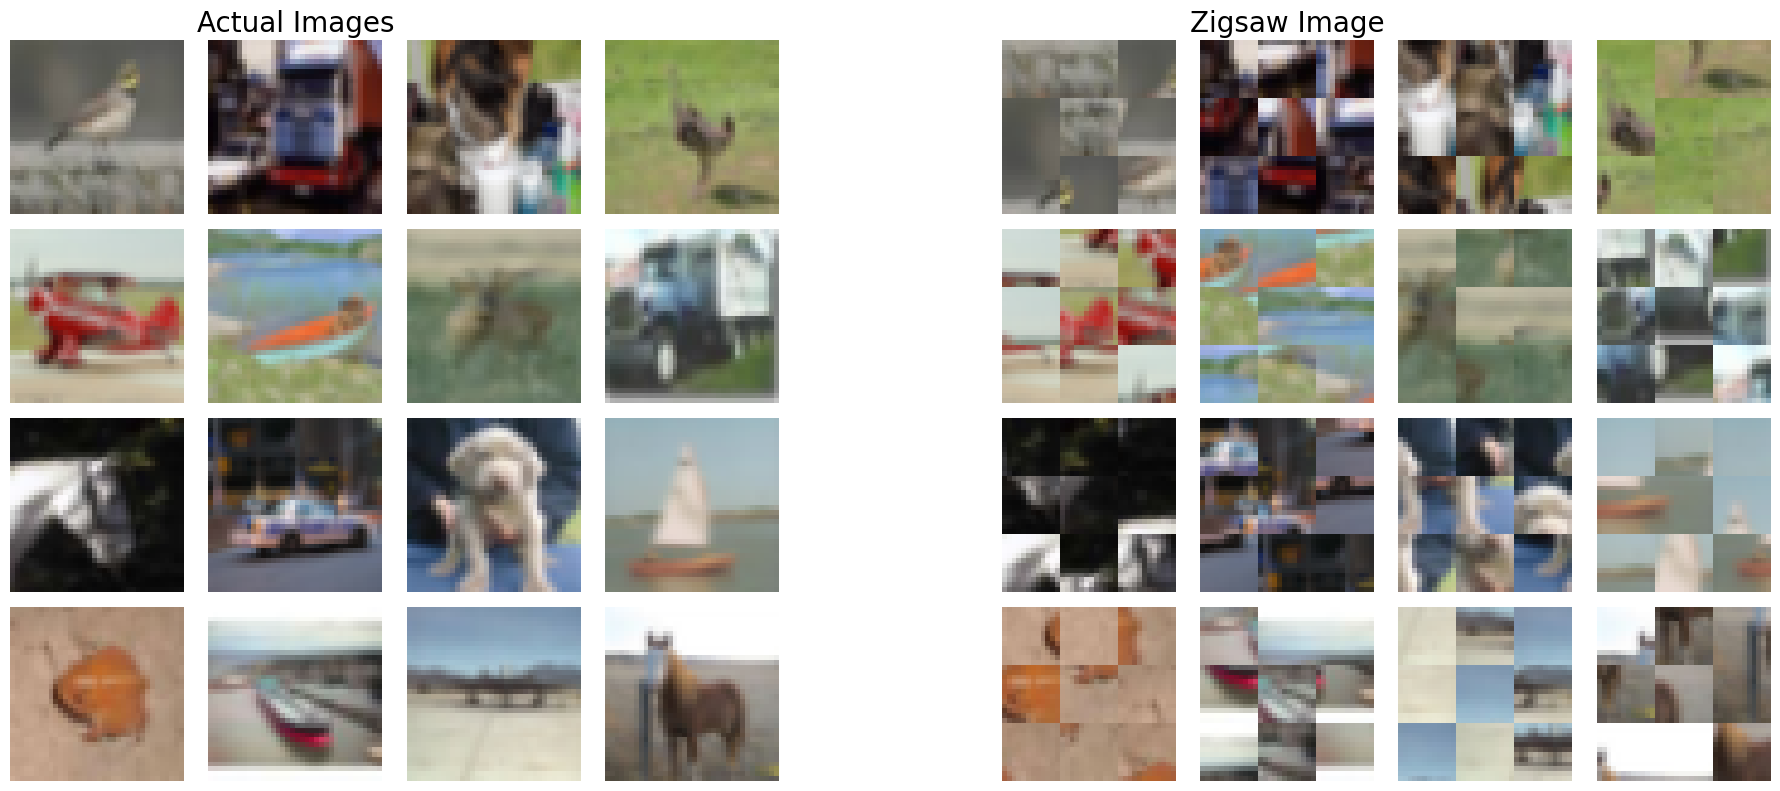

In [96]:
original_img, permuted_img, patches, perm_idx = next(iter(training_loader))
images_visualization(original_img, permuted_img, "Actual Images", "Zigsaw Image")

### Jigsaw Model

In [128]:

# # Metric for accuracy
# from pytorch_lightning.metrics.classification import Accuracy
# import pytorch_lightning as pl

class JigsawModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        
        # Feature Extractor: A series of convolutional layers
        self.featureExtractor = nn.Sequential(
            self.conv_block(3, 16),
            self.conv_block(16, 16),
            nn.MaxPool2d(2),
            self.conv_block(16, 64),
            self.conv_block(64, 64),
            nn.MaxPool2d(2),
            self.conv_block(64, 128), #D P = 0.8
            self.conv_block(128, 128), #128*9 1024
            # self.conv_block(64, 256),
            # self.conv_block(256, 256),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        # Classification Layer: Dense layers with dropout
        self.output = nn.Sequential(
            nn.Dropout(0.65),
            nn.Linear(128*9, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
        
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass',num_classes=num_classes)

    def conv_block(self, in_channels, out_channels):
        # Basic convolution block with Convolution, BatchNorm and ReLU
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward_pass(self, patches):
        # Feature extraction for each patch
        features = [self.featureExtractor(patch) for patch in patches]
        return torch.cat(features, dim=-1)

    def forward(self, x):
        # Assuming x is of shape [batch_size, num_patches, channels, height, width]
        batch_size, num_patches, channels, height, width = x.shape
        patches = torch.split(x, 1, dim=1)  # Split tensor along the patch dimension
        patches = [patch.squeeze(1) for patch in patches]  # Remove the extra dimension
        
        features = self.forward_pass(patches)
        return self.output(features)

    def training_step(self, batch, batch_idx):
        _, _, patches, perm_idx = batch
        preds = self(patches)
        loss = self.criterion(preds, perm_idx)
        acc = self.accuracy(preds, perm_idx)
        self.log_dict({'Train_loss': loss, 'train_acc': acc}, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        _, _, patches, perm_idx = batch
        preds = self(patches)
        loss = self.criterion(preds, perm_idx)
        acc = self.accuracy(preds, perm_idx)
        self.log_dict({'Valid_loss': loss, 'valid_acc': acc}, on_epoch=True)

    def test_step(self, batch, batch_idx):
        _, _, patches, perm_idx = batch
        preds = self(patches)
        loss = self.criterion(preds, perm_idx)
        acc = self.accuracy(preds, perm_idx)
        self.log_dict({"Test_loss": loss, 'test_acc': acc}, on_epoch=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-4)


Initialising the model

In [129]:
torch.set_float32_matmul_precision('medium')
jigsaw_model = JigsawModel(len(selected_permutations))
trainer = pl.Trainer(max_epochs = epochs, devices = [0], log_every_n_steps=10)
trainer.fit(jigsaw_model, training_loader, validation_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | featureExtractor | Sequential         | 271 K 
1 | output           | Sequential         | 2.2 M 
2 | criterion        | CrossEntropyLoss   | 0     
3 | accuracy         | MulticlassAccuracy | 0     
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.014    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 313/313 [00:08<00:00, 35.27it/s, v_num=36]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 313/313 [00:08<00:00, 34.91it/s, v_num=36]


Visualization of training and validation loss

In [105]:
metric = pd.read_csv('./lightning_logs/version_36/metrics.csv')
metric

,Train_loss_step,train_acc_step,epoch,step,Valid_loss,valid_acc,Train_loss_epoch,train_acc_epoch,Test_loss,test_acc
0,7.039089,0.000000,0,9,NaN,NaN,NaN,NaN,NaN,NaN
1,6.950583,0.007812,0,19,NaN,NaN,NaN,NaN,NaN,NaN
2,7.112351,0.000000,0,29,NaN,NaN,NaN,NaN,NaN,NaN
3,7.025833,0.007812,0,39,NaN,NaN,NaN,NaN,NaN,NaN
4,7.034305,0.007812,0,49,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1661,0.021345,0.992188,49,15639,NaN,NaN,NaN,NaN,NaN,NaN
1662,0.003907,1.000000,49,15649,NaN,NaN,NaN,NaN,NaN,NaN
1663,NaN,NaN,49,15649,0.013651,0.9964,NaN,NaN,NaN,NaN
1664,NaN,NaN,49,15649,NaN,NaN,0.024925,0.992975,NaN,NaN


In [106]:
valid_losses = metric[~metric['Valid_loss'].isna()]['Valid_loss'].values
train_losses = metric[~metric['Train_loss_epoch'].isna()]['Train_loss_epoch'].values
valid_accuracy = metric[~metric['valid_acc'].isna()]['valid_acc'].values
train_accuracy = metric[~metric['train_acc_epoch'].isna()]['train_acc_epoch'].values

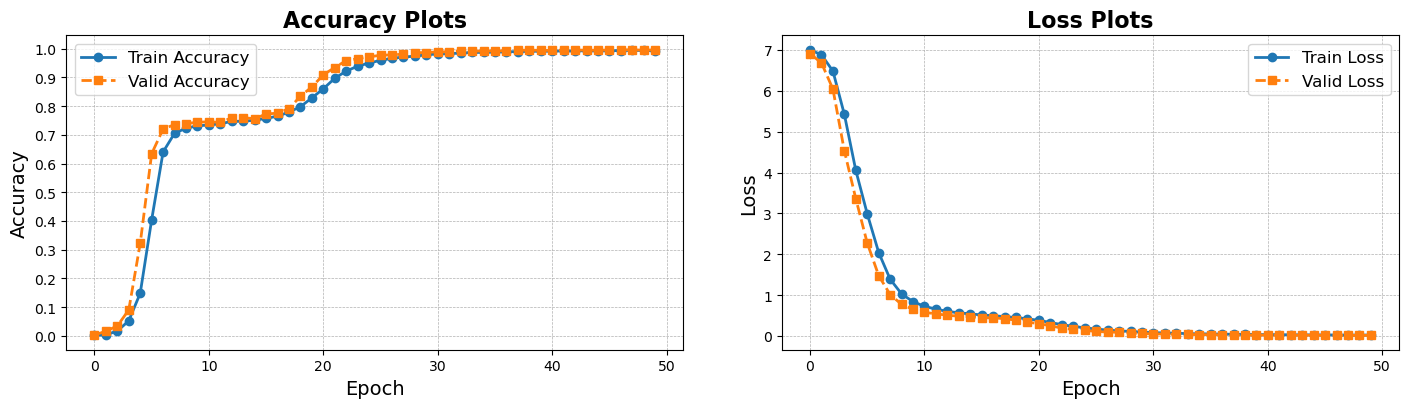

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for Accuracy
axes[0].plot(train_accuracy, 'o-', lw=2, label="Train Accuracy")
axes[0].plot(valid_accuracy, 's--', lw=2, label="Valid Accuracy")
axes[0].set_title('Accuracy Plots', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_yticks(np.arange(0.0, 1.1, 0.1))
axes[0].legend(fontsize=12)

# Plot for Loss
axes[1].plot(train_losses, 'o-', lw=2, label="Train Loss")
axes[1].plot(valid_losses, 's--', lw=2, label="Valid Loss")
axes[1].set_title('Loss Plots', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=14)  # Corrected xlabel from 'Losses' to 'Epoch'
axes[1].set_ylabel('Loss', fontsize=14)  # Corrected ylabel from 'Accuracy' to 'Loss'
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].legend(fontsize=12)

# Layout adjustments
fig.tight_layout(pad=4)

plt.show()

Visualisation of testing loss

In [133]:
trainer.test(jigsaw_model, dataloaders=testing_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 79/79 [00:01<00:00, 72.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test_loss         │   0.014346888288855553    │
│         test_acc          │     0.996399998664856     │
└───────────────────────────┴───────────────────────────┘

[{'Test_loss': 0.014346888288855553, 'test_acc': 0.996399998664856}]

### Converting from Jumbled to Rejumbled images

In [141]:
def rejumble_jigsaw(patches, perm_idx):
    current_perm = selected_permutations[perm_idx]
    rejumbled_img = torch.zeros((3,36,36))
    for i in range(9):
        row, col = current_perm[i]//3, current_perm[i]%3
        row_start, row_end = row*12, row*12+12
        col_start, col_end = col*12, col*12+12
        rejumbled_img[:, row_start:row_end, col_start:col_end] = patches[i].detach().cpu()
    return rejumbled_img

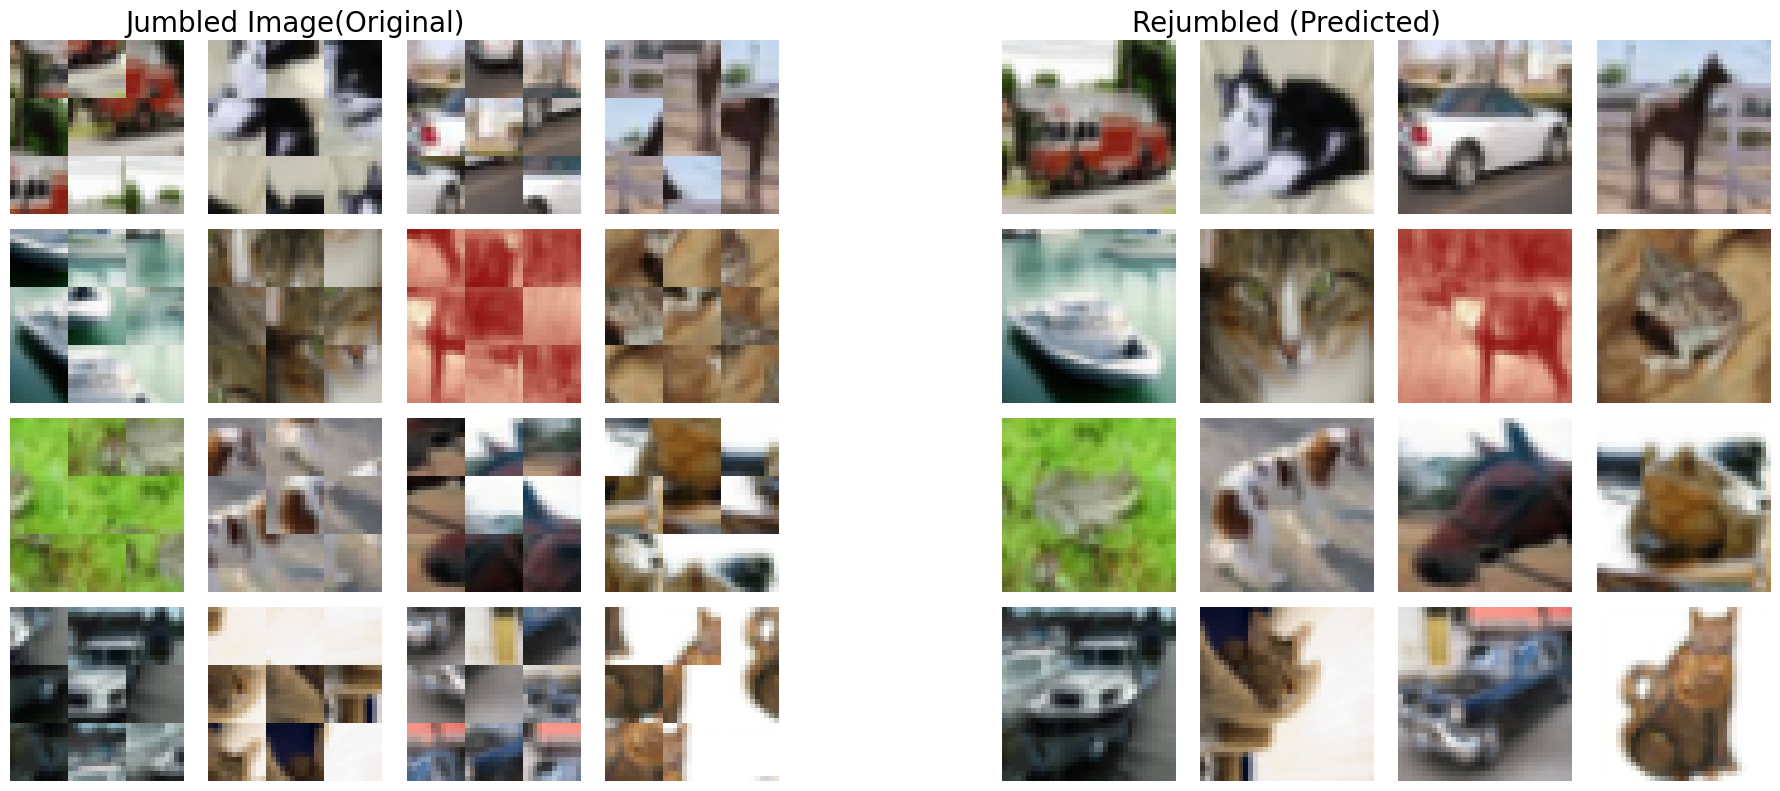

In [142]:
orig_img, permuted_img, patches, perm_idx = next(iter(validation_loader))
predictions = torch.max(jigsaw_model(patches), axis = -1)[1]
rejumbled_images = torch.zeros_like(orig_img)
for i in range(len(orig_img)):
    rejumbled_images[i] = rejumble_jigsaw(patches[i], predictions[i])
images_visualization(permuted_img, rejumbled_images, 'Jumbled Image(Original)', 'Rejumbled (Predicted)')

### Transformations and Dataloader for classification tasks

In [23]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])
cifar10_train = datasets.CIFAR10('./data/', train=True, transform=train_transforms)
cifar10_test = datasets.CIFAR10('./data', train=False, transform=test_transforms)

In [24]:
train_loader = DataLoader(cifar10_train, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, num_workers=2)

### Classification Model

In [25]:
class ClassificationModel(pl.LightningModule):
    def __init__(self, num_classes, num_freeze = -1):
        super().__init__()
        self.featureExtractor = nn.Sequential(
            self.conv_block(3, 16),
            self.conv_block(16, 16),
            nn.MaxPool2d(2),
            self.conv_block(16, 64),
            self.conv_block(64, 64),
            nn.MaxPool2d(2),
            self.conv_block(64, 128), #D P = 0.8
            self.conv_block(128, 128), #128*9 1024
            # self.conv_block(64, 256),
            # self.conv_block(256, 256),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        # Classification Layer: Dense layers with dropout
        self.output = nn.Sequential(
            nn.Dropout(0.65),
            nn.Linear(128*9, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
        
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass',num_classes=10)
        self.freeze_layers(num_freeze)

    def conv_block(self, in_channels, out_channels):
        # Basic convolution block with Convolution, BatchNorm and ReLU
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Assuming x is of shape [batch_size, num_patches, channels, height, width]
        features = self.featureExtractor(x)
        return self.output(features)
    
    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            torch.nn.init.xavier_normal_(layer.weight)
        elif isinstance(layer, nn.Linear):
            torch.nn.init.xavier_normal_(layer.weight)
            # layer.bias.data.fill_(0.0)
    def freeze_layers(self, num_freeze):
        for idx, child in enumerate(self.featureExtractor.children()):
            # Freeze all layers
            if num_freeze == -1:
                for param in child.parameters():
                    param.requires_grad = False
                continue

            else:
                if idx >= num_freeze:
                    break
                for param in child.parameters():
                    param.requires_grad = False
    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.criterion(preds, labels)
        acc = self.accuracy(preds, labels)
        self.log_dict({'Train_loss': loss, 'train_acc': acc}, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.criterion(preds, labels)
        acc = self.accuracy(preds, labels)
        self.log_dict({'Valid_loss': loss, 'valid_acc': acc}, on_epoch=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.criterion(preds, labels)
        acc = self.accuracy(preds, labels)
        self.log_dict({"Test_loss": loss, 'test_acc': acc}, on_epoch=True)

   
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-02)
        return optimizer

    def loss_fxn(self):
        self.criterion = nn.CrossEntropyLoss()


In [26]:
classification_model = ClassificationModel(num_classes=len(selected_permutations), num_freeze=7)
checkpoint = torch.load('./lightning_logs/version_36/checkpoints/epoch=49-step=15650.ckpt')
classification_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Replacing the output layer 

In [85]:
# Removing the output with classifier
classification_model.output = nn.Sequential(nn.Dropout(p = 0.7),
                                    nn.Linear(2048, 1024),
                                    nn.BatchNorm1d(num_features=1024),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(1024, 10) # Since CIFAR 10 have 10 classes
                                   )

Training for classification tasks(keeping the last cnn layer unfreezed)

In [86]:
epochs = 50
trainer = pl.Trainer(max_epochs = epochs, devices=[0], log_every_n_steps=10)
trainer.fit(classification_model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | featureExtractor | Sequential         | 271 K 
1 | output           | Sequential         | 2.1 M 
2 | criterion        | CrossEntropyLoss   | 0     
3 | accuracy         | MulticlassAccuracy | 0     
--------------------------------------------------------
2.3 M     Trainable params
123 K     Non-trainable params
2.4 M     Total params
9.527     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 391/391 [00:05<00:00, 77.03it/s, v_num=49] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 391/391 [00:05<00:00, 75.95it/s, v_num=49]


In [89]:
metric = pd.read_csv('./lightning_logs/version_49/metrics.csv')
metric.head()

,Train_loss_step,train_acc_step,epoch,step,Valid_loss,valid_acc,Train_loss_epoch,train_acc_epoch
0,1.794249,0.335938,0,9,NaN,NaN,NaN,NaN
1,1.627310,0.437500,0,19,NaN,NaN,NaN,NaN
2,1.573609,0.453125,0,29,NaN,NaN,NaN,NaN
3,1.653357,0.484375,0,39,NaN,NaN,NaN,NaN
4,1.347301,0.531250,0,49,NaN,NaN,NaN,NaN


In [90]:
valid_losses = metric[~metric['Valid_loss'].isna()]['Valid_loss'].values
train_losses = metric[~metric['Train_loss_epoch'].isna()]['Train_loss_epoch'].values
valid_accuracy = metric[~metric['valid_acc'].isna()]['valid_acc'].values
train_accuracy = metric[~metric['train_acc_epoch'].isna()]['train_acc_epoch'].values

### Visualisation for classification tasks

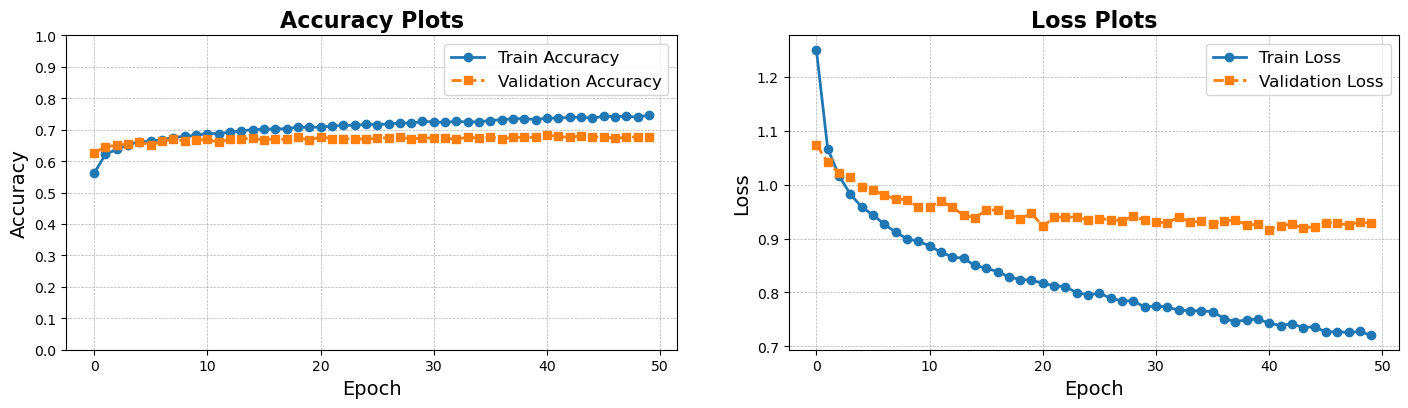

In [103]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for Accuracy
axes[0].plot(train_accuracy, 'o-', lw=2, label="Train Accuracy")
axes[0].plot(valid_accuracy, 's--', lw=2, label="Validation Accuracy")
axes[0].set_title('Accuracy Plots', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_yticks(np.arange(0.0, 1.1, 0.1))
axes[0].legend(fontsize=12)

# Plot for Loss
axes[1].plot(train_losses, 'o-', lw=2, label="Train Loss")
axes[1].plot(valid_losses, 's--', lw=2, label="Validation Loss")
axes[1].set_title('Loss Plots', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=14)  # Corrected ylabel
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].legend(fontsize=12)

# Layout adjustments
fig.tight_layout(pad=4)

plt.show()

# Gradcam Visualisation

In [99]:

def gradcam_visualization(img, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move the image and model to the appropriate device
    img = img.unsqueeze(0).to(device)
    model = model.to(device)
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    # We assume that the model has been frozen externally (if required), so we do not include model.unfreeze() here

    # Extract features and compute the forward pass
    activation_network = model.featureExtractor[:-3]
    feature_maps = activation_network(img)
    logits = model(img)
    _, max_logit_indices = torch.max(logits, dim=-1)
    model.zero_grad()
    logits[0, max_logit_indices[0]].backward(retain_graph=True)

    # Compute Grad-CAM heatmap
    gradients = model.featureExtractor[-3][0].weight.grad.data
    gradients_mean = gradients.mean((0, 2, 3))
    weighted_feature_maps = feature_maps[0] * gradients_mean[:, None, None]
    heatmap = weighted_feature_maps.mean(0).cpu().detach().numpy()

    # Normalize heatmap between 0 and 255
    heatmap = 255 * (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = heatmap.astype(np.uint8)
    
    # Prepare the original image for visualization
    img_np = (255 * np.transpose(img[0].cpu().numpy(), (1, 2, 0))).astype(np.uint8)

    # Resize heatmap to match the original image size and apply colormap
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_colored = cv2.applyColorMap(255 - heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose heatmap on the original image
    superimposed_img = (0.3 * heatmap_colored + 0.7 * img_np).astype(np.uint8)

    # Convert back to torch tensor
    superimposed_tensor = torch.from_numpy(np.transpose(superimposed_img, (2, 0, 1))).float() / 255.

    return superimposed_tensor


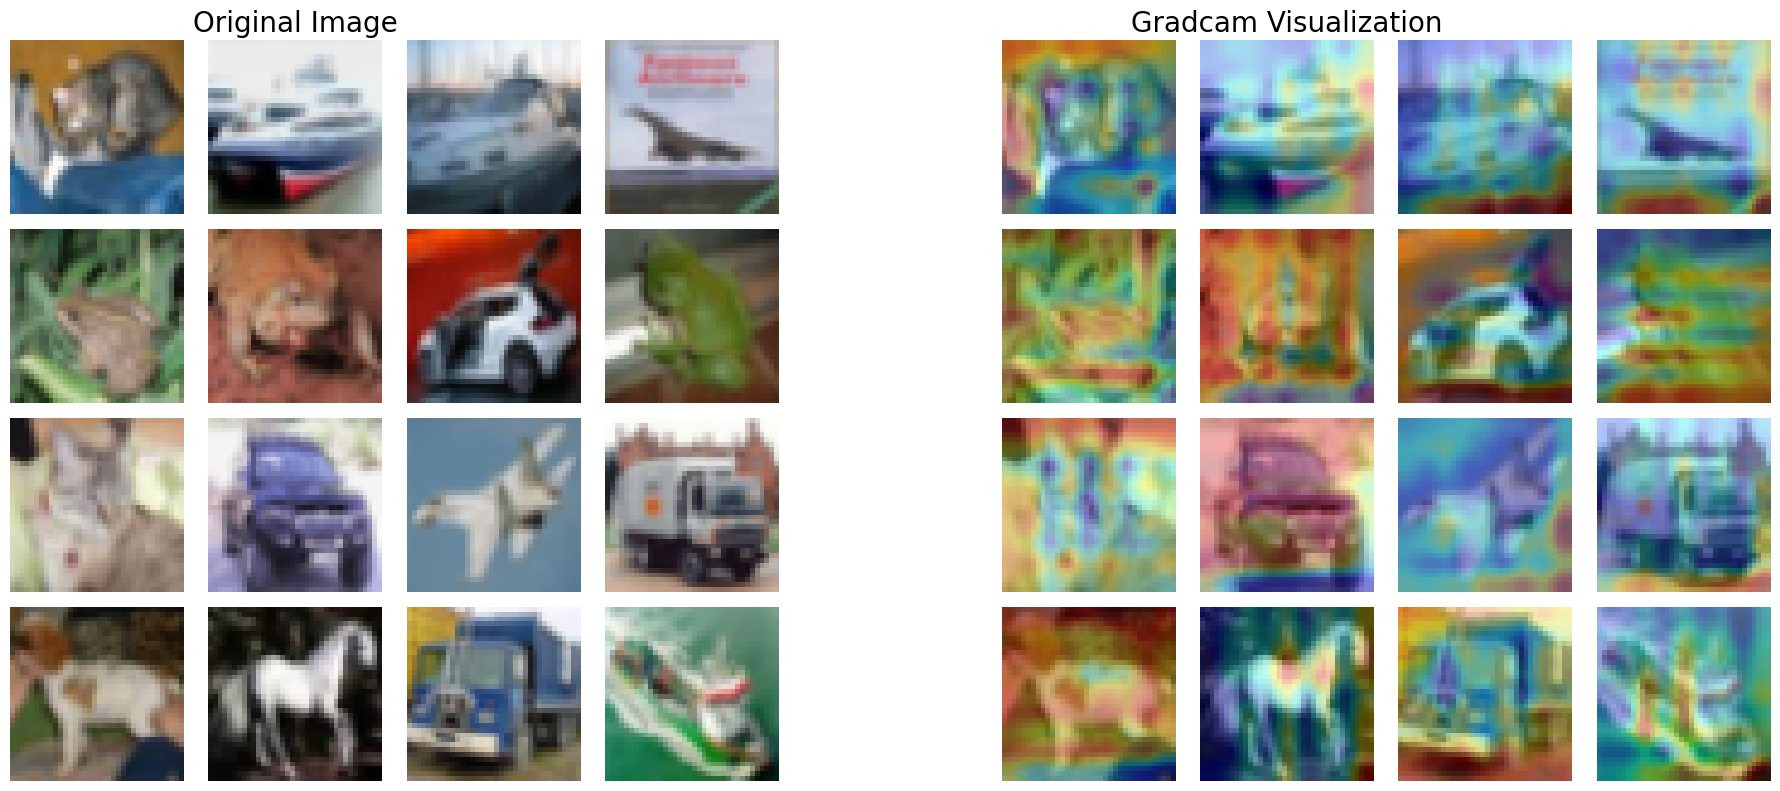

In [100]:
imgs, lbls= next(iter(test_loader))
grad_cam_images = torch.zeros_like(original_img)
for i in range(len(original_img)):
    grad_cam_images[i] = gradcam_visualization(imgs[i], classification_model)
images_visualization(imgs, grad_cam_images, 'Original Image', 'Gradcam Visualization')